# Finite Rate of Innovation (FRI) Introductory Tutorial

This is a tutorial on the Finite Rate of Innovation (FRI) theory and method from the following paper ([IEEE link](https://ieeexplore.ieee.org/document/1003065/)):

    M. Vetterli, P. Marziliano and T. Blu, "Sampling signals with finite rate of innovation," in IEEE Transactions 
    on Signal Processing, vol. 50, no. 6, pp. 1417-1428, Jun 2002.
    
The purpose is to breakdown the underlying approach in a **hands-on** manner, i.e. with code and (hopefully) very clear and intuitive explanations. In this notebook, we will consider the **_noiseless baseband_** case as to develop the intuition behind FRI. In another notebook, we will tackle _noisy_ and _modulated_ situations and also practical applications of FRI. For a more rigorous treatment, please refer to the paper!

This is the breakdown of this notebook:
1. [The backstory](#intro): brings us back to the Nyquist-Shannon sampling theorem / sampling of bandlimited signal in order to motivate the idea of _finite rate of innovation_ (FRI).
2. [FRI intuition / terminology](#fri): defines what we mean by FRI and how we can think (and sample) more generally with this idea in place.
3. [Recovery of pulse stream parameters (intuitive buildup)](#buildup): describes the recovery process for an FRI signal that is not necessarily bandlimited. We supplement (admitedly) verbose explanations with code snippets to numerically verify steps in the recovery process.
4. [Recovery of pulse stream parameters (short)](#short): summarizes the approach from the previous section.
5. [Recovery of pulse stream parameters (code)](#code): applies the recovery process in Python.
6. [Recovery of pulse stream parameters (interactive)](#interactive): interactive widgets to modify signal parameters.
7. [Summary / takeaways](#summary): summarizes the main points, motivates the noisy situation, and points to further reading.

__Pre-requisite theory:__
- [Nyquist-Shannon Sampling Theory](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)
- [Fourier transform properties](https://en.wikipedia.org/wiki/Fourier_transform#Tables_of_important_Fourier_transforms), in particular the convolution theorem, the Fourier transform of $\delta(t)$, and shifting in the time domain.
- [Fourier Series](https://en.wikipedia.org/wiki/Fourier_series), [Z-transform](https://en.wikipedia.org/wiki/Z-transform#Unilateral_Z-transform), [DFT](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)
- Linear algebra fundamentals: projection, unitary matrix.

Let's first import the necessary libraries.

In [1]:
%matplotlib inline

import numpy as np
from scipy.linalg import toeplitz, lstsq, solve_toeplitz
import ipywidgets as widgets
from ipywidgets import interactive

sys.path.append('..')
import plot_settings

# fix random number generator
seed = 0
rng = np.random.RandomState(seed)

<a id='intro'></a>
# 1. The backstory

The fundamental [Nyquist-Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) sets a lower bound on the sampling rate in order to perfectly recover bandlimited signals, namely in order to perfectly reconstruct a signal (from its samples) with maximum frequency - $ f_m $ - it is necessary to sample it at every $1/(2f_m)$ seconds.

But signals in real-life are typically not bandlimited. However, we are usually only interested in recovering up until a certain frequency, e.g. humans can only hear up until 20 kHz so we typically sample at 44.1 or 48 kHz. Moreover, as real-life signals are not bandlimited, it is necessary to _project_ our measured signal into this bandlimited space before sampling it.

Below is a visual example. Let's say we have a signal of infinite bandwidth, i.e. it contains frequencies from $-\infty$ to $\infty$. We can't physically create this but imagine the signal below continues for all frequencies! 

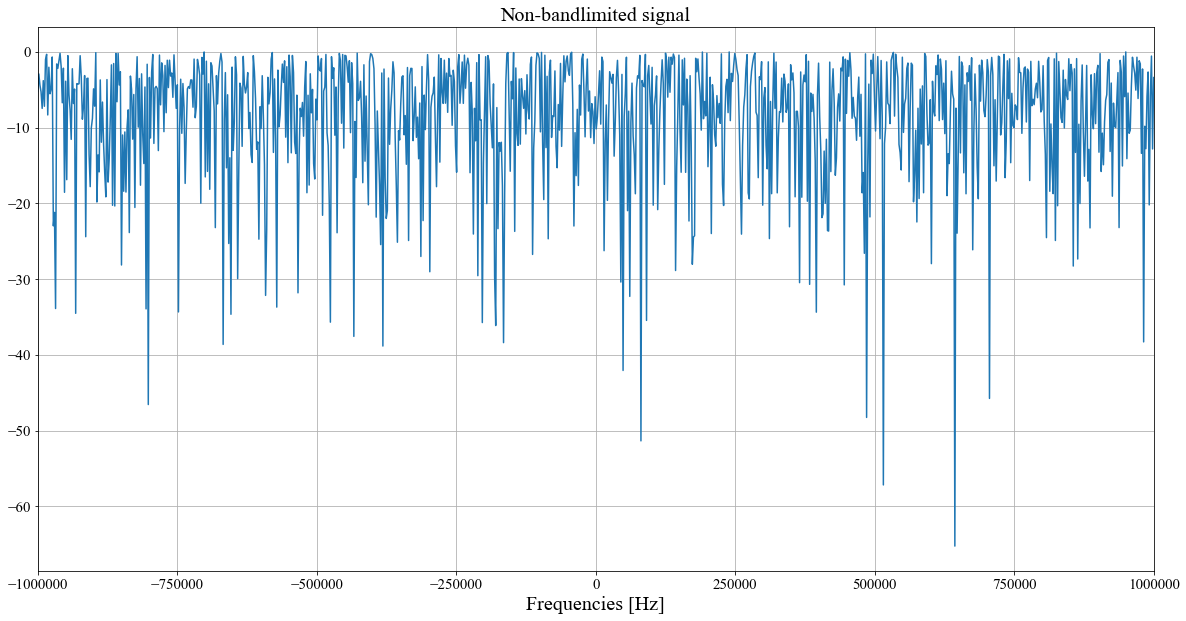

In [2]:
# create synthetic spectrum
n_vals = 1000
spectrum = rng.rand(n_vals)
freqs = np.linspace(-1e6, 1e6, n_vals)

plt.figure(figsize=(20,10))
plt.title("Non-bandlimited signal", fontsize=20)
plt.plot(freqs, 20*np.log10(abs(spectrum)))
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("Frequencies [Hz]", fontsize=20);

Now in order to _project_ this to a bandlimited space, e.g. within $[-48000,48000]$ Hz, we will need "cut off" the frequencies outside of our desired range. This can be done by applying a _low-pass filter_. For our purposes, we will use a very simple, (but very ideal) low pass filter that is equal to 1 within our desired range and 0 outside, as shown below.

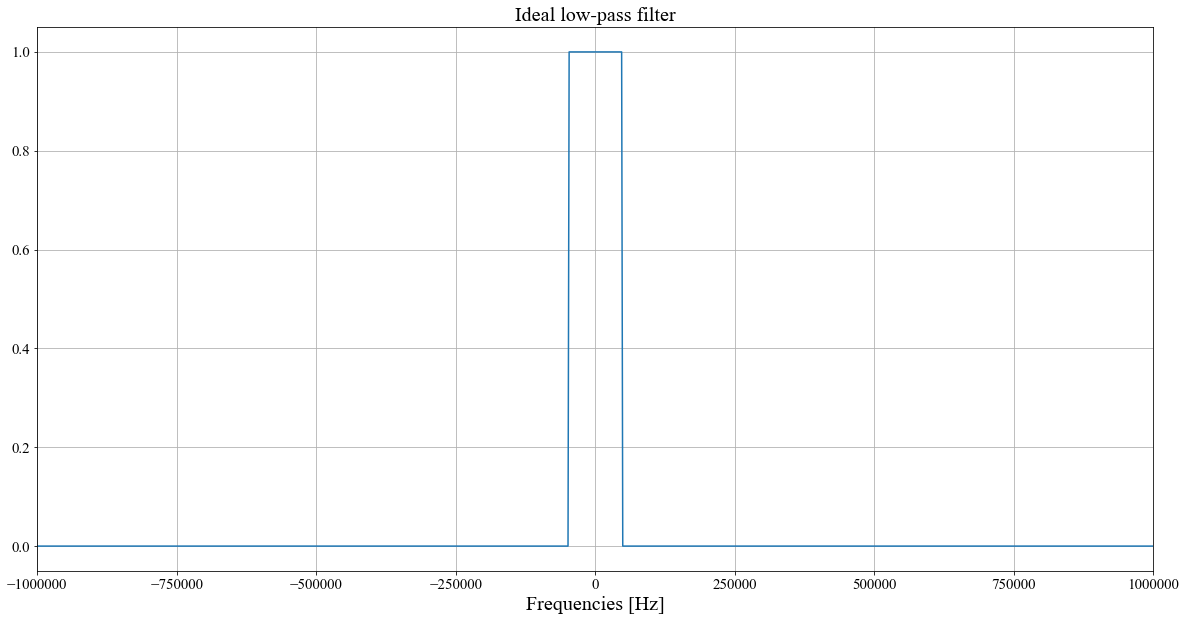

In [3]:
# create ideal low-pass filter
cutoff = 48000
lpf = np.ones(n_vals)
lpf[freqs<-cutoff] = 0
lpf[freqs>cutoff] = 0

plt.figure(figsize=(20,10))
plt.title("Ideal low-pass filter", fontsize=20)
plt.plot(freqs, lpf)
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("Frequencies [Hz]", fontsize=20);

Filtering / convolving our original signal in time is equivalent to multiplying the two spectra, i.e. [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem). Therefore, projecting our non-bandlimited signal to the bandlimited space is a simple pointwise multiplication in frequency.

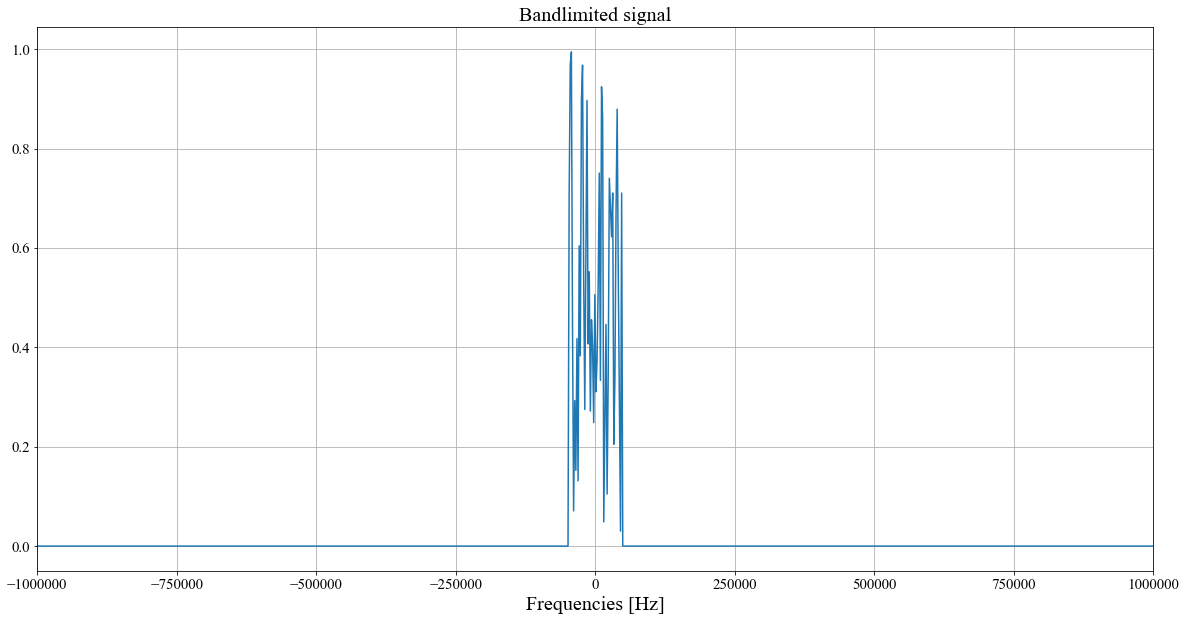

In [4]:
spectrum_bl = spectrum*lpf

plt.figure(figsize=(20,10))
plt.title("Bandlimited signal", fontsize=20)
plt.plot(freqs, spectrum_bl)
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("Frequencies [Hz]", fontsize=20);

Now in order to sample the _bandlimited_ signal above so that it can be perfectly reconstructed from the measured samples, it is necessary to sample it at $\geq(2 f_m)$ Hz or obtain samples at every $1/(2f_m)$ seconds.

This low-pass filter applied to our real-life non-bandlimited signal (in order to project it to a bandlimited space) is often referred to as an _anti-aliasing_ filter.

With an anti-aliasing filter, we are projecting our non-bandlimited signal onto a bandlimited space for which we are able to reconstruct this bandlimited approximation perfectly according to the Nyquist-Shannon Sampling Theorem. This is fine when the signal we want to recover is only within a certain bandwidth (such as audio), but what if our signal of interest is in fact not bandlimited? For example, a dirac which is infinitely short in time but has infinite bandwidth:

\begin{equation}
y(t) = \delta(t-t_0) \xrightarrow{\mathscr{F}} Y(f) = \exp(-j2\pi f t_0)
\end{equation}

We would certainly be able to sample and reconstruct a bandlimited version of this signal. But what if we are interested in the exact location of the dirac or as in the signal below the exact location of several diracs and their corresponding amplitudes.

\begin{equation}
y(t) = \sum_{k=0}^{K-1}c_k\cdot\delta(t-t_k) \xrightarrow{\mathscr{F}} Y(f) = \sum_{k=0}^{K-1}c_k\cdot\exp(-j2\pi f t_k)
\end{equation}

<a id='fri'></a>
# 2. FRI intuition / terminology

We can generalize the sum of diracs above to the signal below:

\begin{equation}
y(t) = \sum_{k=0}^{K-1}c_k\cdot h(t-t_k) \xrightarrow{\mathscr{F}} Y(f) = H(f) \sum_{k=0}^{K-1}c_k\cdot\exp(-j2\pi f t_k)
\end{equation}

where $h(t)$ is some known pulse shape and $H(f)$ is its Fourier transform. In the previous case, we were simply considering that the pulse was $\delta(t)$ whose Fourier Transform we know to be simply $1$ (hence the infinite bandwidth).

One observation we can make about this signal is that (given we know the pulse shape), there are really only $2K$ unknown parameters: the $K$ locations $\{t_k\}_{k=0}^{K-1}$ and the $K$ amplitudes $\{c_k\}_{k=0}^{K-1}$. We have made a __huge__ and __very strong__ assumption however! We are expecting our signal to be of the model described above, i.e. a finite sum of pulses, only one type of pulse which we assume to know, and to consist of a certain number $K$ pulses.

In the general bandlimited case, our only assumption was that our signal had (essentially) no frequency content above a certain maximum frequency $ f_m$ (if not we apply an anti-aliasing filter). Moreover, we had to take $1/(2f_m)$ samples in order to reconstruct this best approximation of our signal in the bandlimited space. In other words any bandlimited signal can be seen as having $1/(2f_m)$ degrees of freedom per unit of time. The original paper on FRI refers to this degrees of freedom per unit of time as the __rate of innovation__, and in the bandlimited case we can say that we have a __finite rate of innovation__ due the finite number of samples needed per unit of time to reconstruct the signal. Moreover, for the bandlimited case we have a _finite rate of innovation_ of $\rho_{BL}=2f_m$.

Could we say that our finite sum of pulses of possible infinite bandwidth has a finite rate of innovation? Yes we can! If our finite sum of pulses has a duration or period of length $\tau$, we can say that our signal has a _finite rate of innovation_ of $\rho_{K\_pulses}=\dfrac{2K}{\tau}$.

_Let's put some numbers to this terminology._ Let's say we have a signal of length 1 second. Perhaps it's not bandlimited so we apply an anti-aliasing filter so that its bandwidth is limited to $[-f_m, f_m]$. In order to faithfully reconstruct this bandlimited approximation, we would need to take the following number of samples:

\begin{equation}
\text{number of samples (bandlimited)} = \dfrac{\text{duration}}{\text{sampling period}} = \dfrac{\text{1 second}}{1 / (2f_m) \text{ seconds}} = 2f_m \text{ samples}
\end{equation}

Whereas let's say we know that our signal is a finite sum of $K$ (known) pulses. Using our intuition that there are only $2K$ degrees of freedom for the signal duration, we only need $2K$ samples for that 1 second duration. Moreover, our bandlimited approach may not be faithful to the original signal as we had to project it to a bandlimited space. On the other hand, if we are able to obtain the amplitudes and locations of our finite sum of pulses this would be a much more faithful representation of our original signal (if our assumption about it being a sum of known pulses is correct).

So as we can see the number of samples for the bandlimited approximation and reconstruction depends on our signal's period / duration (if not periodic) and the highest frequency as such:

\begin{equation}
\text{number of samples (bandlimited)} = (2f_m \times \text{duration})
\end{equation}

While the number of samples for the sum of pulses assumption depends on the number of pulses:

\begin{equation}
\text{number of samples (sum of pulses)} = (2K)
\end{equation}

Or in general (as bandlimited signals are a case of FRI signals):

\begin{equation}
\text{number of samples (FRI)} = \rho \times \text{duration}
\end{equation}

In the plot below, you can play around with the signal duration / period and the highest frequency for the bandlimited approximate to see how the _rate of innovation_ varies. In fact, the rate of innovation is equivalent to our sampling rate. 

Remember the bandlimited signal is an **_approximation_** while recovering the parameters for the sum of pulses would be an exact reconstruction (if our signal model assumption is correct).

In [5]:
n_pulses = np.arange(1,1e4)

def f(fm, tau):
    fs_pulses = 2*n_pulses/tau
    fs_bl = 2*fm

    plt.figure(figsize=(20,10))
    plt.title("Duration $tau$ = %.03f s" % tau, fontsize=25)
    plt.plot(n_pulses, fs_pulses, label="Perfect recovery of pulses")
    axhline(fs_bl, color='r', label="Bandlimited approx, $f_{m}$ = %d Hz" %fm)
    plt.grid()
    plt.xlabel("Number of pulses", fontsize=20)
    plt.ylabel("Sampling rate / rate of innovation [Hz]", fontsize=20)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend(fontsize=20);
    plt.show()

interactive_plot = widgets.interact(f, fm=(20000, 100000, 5000), tau=(0.1, 1.0, 0.1))

A Jupyter Widget

<a id='buildup'></a>
# 3. Recovery of pulse stream parameters (intuitive buildup)

Now that we have motivated the number of samples needed to reconstruct such a signal:

\begin{equation}
y(t) = \sum_{k=0}^{K-1}c_k\cdot h(t-t_k)
\end{equation}

Let's explain how we will recover these $2K$ unknown parameters $\{t_k\}_{k=0}^{K-1}$ and $\{c_k\}_{k=0}^{K-1}$. The "trick" is looking at this signal in another perspective, i.e. the frequency domain. Before we saw that we can express $y(t)$ in the frequency domain as such:

\begin{align}
Y(f) &= \sum_{k=0}^{K-1}c_k\cdot H(f)\exp(-j2\pi f t_k)\\
&= H(f) \sum_{k=0}^{K-1}c_k\cdot \exp(-j2\pi f t_k)
\end{align}

As we will be dealing with discrete samples in time, we are also limited to working with discrete samples in frequency. We typically "take" time-domain samples to the frequency domain with the [DFT/FFT](https://en.wikipedia.org/wiki/Discrete_Fourier_transform). Moreover, the DFT of one period of a signal (we can simply make our pulse stream periodic by repeating it at every $\tau$ seconds) is equivalent to the Fourier Series coefficients of the bandlimited version multiplied by $N$, where $N$ is the number of samples (more explanation [here](https://www.dsprelated.com/freebooks/mdft/Relation_DFT_Fourier_Series.html)). 

The Fourier Series coefficients of our pulse stream are given by:

\begin{equation}
Y[m] = \dfrac{1}{\tau}H(\dfrac{m}{\tau}) \sum_{k=0}^{K-1}c_k\cdot\exp(-j2\pi m t_k/\tau), \hspace{0.5cm} m\in\mathbb{Z}
\end{equation}

Imagine we project our pulse stream to some bandlimited space (we will talk more precisely about the operation/filter to project $X[m]$ later):

\begin{equation}
Y_{BL}[m] = 
\begin{cases}
\dfrac{1}{\tau} H(\dfrac{m}{\tau}) \sum_{k=0}^{K-1}c_k\cdot \exp(-j2\pi m t_k/\tau), \hspace{0.2cm} & m\in\mathbf{M}   \\[0.5cm]
\text{0},      &  m\not\in\mathbf{M}   
\end{cases}
\end{equation}

Now that we have projected our signal $y(t)$ to this bandlimited space $y_{BL}(t)$, when we take discrete samples of the bandlimited signal $\{y_{BL}(nT_s)\}_{n=0}^{N-1}$ (where $T_s$ is the sampling period), taking the DFT of these discrete samples will allow us to obtain the Fourier Series coefficients as such:

\begin{equation}
\mathbf{Y}_{BL} = \dfrac{\text{DFT}([y_{BL}[0], y_{BL}[1], \ldots, y_{BL}[N-1]])} {N}
\end{equation}

If we remove the frequency spectrum of the pulse, i.e. $X[m] = \dfrac{Y_{BL}[m]}{H(m/\tau)}$:

\begin{equation}
X[m] = \dfrac{1}{\tau}\sum_{k=0}^{K-1}c_k\cdot \exp(-j2\pi m t_k/\tau)
\end{equation}

we observe a linear combination of $K$ complex exponentials, which is very similar to the type of signal that past research has attempted to recover in [spectral estimation](https://en.wikipedia.org/wiki/Spectral_density_estimation#Finite_number_of_tones), i.e. a finite number of tones (in this case the "tones" are defined by the $t_k$ values). There are some grid-search approaches to determine these frequencies/tones, e.g. with <a href="https://en.wikipedia.org/wiki/MUSIC_(algorithm)">MUSIC</a>; however, we will ultimately be limited to our selected grid values.

A _gridless_ approach is possible with the use of an **_annihilating filter_**. Let's first use a more convenient notation that will also _generaralize_ the annihilating filter approach. Let $u_k = \exp(-j2\pi t_k/\tau) $ so that we can write:

\begin{equation}
X[m] = \dfrac{1}{\tau} \sum_{k=0}^{K-1}c_k\cdot u_k^m
\end{equation}

Now in order to simplify our analysis, imagine that we are only dealing with one complex exponential, or in the general case a single $u_k$, and we will drop the $(1/\tau)$ factor as it is constant for all Fourier coefficients and can be included as part of the $c_k$ parameter for now:

\begin{align}
X_k[m] &=  c_k\cdot u_k^m\\
\Rightarrow \mathbf{X}_k &= c_k \cdot [\ldots, u_k^{-1}, 1, u_k, u_k^{2}, \ldots]
\end{align}

If we consider the following two-tap filter:

\begin{align}
\mathbf{A}_{k'} = [1, -u_k] = \begin{bmatrix} A_{k'}[0],\hspace{0.2cm} A_{k'}[1] \end{bmatrix}
\end{align}

We can observe that the convolution between $\mathbf{A}_{k'}$ and $\mathbf{X}_k$ is zero! Remember that in a convolution we flip one of the signals (we flip $\mathbf{A}_{k'}$ below) and "slide" it along the other signal, computing the output over the support of the shorter signal.

\begin{align}
&\vdots\\
Z_k[0] &= \begin{bmatrix} A_{k'}[1],\hspace{0.2cm} A_{k'}[0]  \end{bmatrix} \cdot \begin{bmatrix} X_k[-1]\\ X_k[0] \end{bmatrix} = c_k(-1 + 1) = 0 \\
Z_k[1] &= \begin{bmatrix} A_{k'}[1],\hspace{0.2cm} A_{k'}[0]\end{bmatrix} \cdot \begin{bmatrix} X_k[0]\\ X_k[1] \end{bmatrix} = c_k(-u_k + u_k) = 0 \\
&\vdots&\\
Z_k[m] &= \begin{bmatrix} A_{k'}[1],\hspace{0.2cm} A_{k'}[0] \end{bmatrix} \cdot \begin{bmatrix} X_k[m-1]\\ X_k[m] \end{bmatrix} = c_k(-u_k^m + u_k^m) = 0 \\
&\vdots
\end{align}



Now we can also see the need for removing the pulse spectrum! If this were not removed, we could have different weightings for adjacent $\mathbf{X}_k[m]$'s, which wouldn't necessarily result in the convolution being equal to 0. Below is a short code snippet to verify this "annihilating" phenomenon numerically.

In [6]:
ck = 1
tk = 0.1
tau = 1

Ak = [1, -np.exp(-1j*2*np.pi*tk/tau)]
print("Coefficients of Ak : ", end="")
print(Ak)
Xk = ck*np.exp(np.arange(-10,10)*(-1j*2*np.pi*tk/tau))
Zk = np.abs(np.convolve(Ak, Xk, mode='valid'))
print()
print("Ak conv Xk = ", end="")
print(Zk)

Coefficients of Ak : [1, (-0.80901699437494745+0.58778525229247314j)]

Ak conv Xk = [  1.15806865e-16   0.00000000e+00   2.77555756e-17   1.24126708e-16
   5.55111512e-17   3.90393697e-17   1.11022302e-16   2.77555756e-17
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.11022302e-16
   0.00000000e+00   2.77555756e-17   0.00000000e+00   7.19829328e-17
   5.55111512e-17   1.24126708e-16   2.77555756e-17]


This nice result happens because we take **_uniform_** samples of the complex exponential $\mathbf{X}_k$ and our two-tap annihilating filter has a phase difference (between the coefficient) equivalent to the phase difference between adjacent samples of $\mathbf{X}_k$.

If we consider a convolution of $K$ filters similar to $\mathbf{A}_{k'}$.

\begin{align}
\mathbf{A} &= \mathbf{A}_0 \ast \mathbf{A}_1 \ast \cdots \ast\mathbf{A}_{K-1}
\end{align}

convolving $\mathbf{A}$ with $\mathbf{X}$ will also equal to zero as we will effectively _annihilate_ all the complex exponentials in $ \mathbf{X}$!

\begin{align}
\mathbf{Z} &= \mathbf{A} \ast \mathbf{X} \\
&= (\mathbf{A}_0 \ast \mathbf{A}_1 \ast \cdots \ast \mathbf{A}_{K-1}) \ast (\sum_{k=0}^{K-1} \mathbf{X}_k)\\
&= \sum_{k=0}^{K-1} (\mathbf{A}_0 \ast \mathbf{A}_1 \ast \cdots \ast \mathbf{A}_{K-1}) \ast\mathbf{X}_k
\end{align}


where we have used the linearity of convolution. Now if we use the commutative and associative properties of convolution:

\begin{align}
&= \sum_{k=0}^{K-1} (\mathbf{A}_0 \ast \mathbf{A}_1 \ast \cdots \ast \mathbf{A}_{k'-1} \ast \mathbf{A}_{k'+1} \ast\cdots \ast \mathbf{A}_{K-1}) \ast \mathbf{A}_{k'}\ast\mathbf{X}_k\\
&= \sum_{k=0}^{K-1} (\mathbf{A}_0 \ast \mathbf{A}_1 \ast \cdots \ast \mathbf{A}_{k'-1} \ast \mathbf{A}_{k'+1} \ast\cdots \ast\mathbf{A}_{K-1}) \ast \mathbf{0}\\
&= \mathbf{0}
\end{align}

where we have used our result from before that $\mathbf{A}_{k'}\ast\mathbf{X}_k = \mathbf{0}$

Let's again observe this annihilating phenomenon numerically, but on multiple $\mathbf{X}_k$'s.

In [7]:
tau = 1
K = 5
tk_vals = rng.uniform(high=tau, size=K)
ck_vals = rng.randn(K)

# compute full annihilating filter
A = np.ones(1)
for tk in tk_vals:
    Ak = [1, -np.exp(-1j*2*np.pi*tk/tau)]
    A = np.convolve(A, Ak)
print("Coefficients of A : ", end="")
print(A)

# compute sum of complex exponentials
m_vals = np.arange(-K, K+1)
X = np.zeros(len(m_vals), dtype=np.complex)
for idx, m in enumerate(m_vals):
    X[idx] = np.dot(ck_vals, np.exp(-1j*2*np.pi*m*tk_vals/tau)) / K
    
# check convolution
Z = np.abs(np.convolve(A, X, mode='valid'))
print()
print("A conv X = ", end="")
print(Z)

Coefficients of A : [ 1.00000000+0.j          0.11907451-1.03035267j -1.68441568+0.76070668j
  0.16240483+1.84107455j  0.83978007-0.60874855j -0.49007870-0.87167819j]

A conv X = [  5.18516943e-16   1.11886302e-16   1.66677951e-16   1.14439170e-16
   1.11022302e-16   5.38915796e-16]


Great but what can we do with $\mathbf{A}$? This is where classic DSP tools come to play. If we take the Z-transform of $A[m]$, keeping in mind that convolution in one domain is multiplication in the other:

\begin{align}
A(z) &= \prod_{k'=0}^{K-1} (\sum_{m\in[0,1]}A_{k'}[m] \hspace{0.1cm} z^{-m}) \\
&= \prod_{k=0}^{K-1} (A_{k'}[0] + A_{k'}[1] \hspace{0.1cm} z^{-1}) \\
&= \prod_{k=0}^{K-1} (1 - u_k z^{-1}) \\
\end{align}

We can observe that the zeros of $A(z)$ correspond to the $\{u_k\}_{k=0}^{K-1}$ functions that make up our signal of interest. Moreover, we know how to find our desired parameters, the time locations $\{t_k\}_{k=0}^{K-1}$, from these functions.

\begin{align}
u_k &= \exp(-j2\pi t_k/\tau)\\
\Rightarrow  t_k &= \Re{(\dfrac{j \tau \ln(u_k)} {2\pi})}
\end{align}

In [8]:
uk = np.roots(A)
uk = uk / np.abs(uk)  # on unit circle
# between [0, tau]
tk_hat = np.real(1j * tau * np.log(uk) / (2 * np.pi))
tk_hat = tk_hat - np.floor(tk_hat / tau) * tau
print("||tk - tk_hat||_2 = %f " % np.linalg.norm(np.sort(tk_vals)-np.sort(tk_hat)))

||tk - tk_hat||_2 = 0.000000 


We can generalize the annihilating filter as such: if we can represent our desired parameters $\{\Theta_k\}_{k=0}^{K-1}$ as a set of bijective functions $\{u_k(\Theta_k)\}_{k=0}^{K-1}$ (meaning we can uniquely determine $\Theta_k$ from $u_k(\Theta_k)$), determining the parameters $\{\Theta_k\}_{k=0}^{K-1}$ can be done by:

1. Finding the annihilating filter $\mathbf{A}$ of $K+1$ taps that has zeros at $\{u_k\}_{k=0}^{K-1}$ (dropping dependence on $\{\Theta_k\}_{k=0}^{K-1}$ as the $k$ subscript is sufficient).
2. Inverting the $\{u_k\}_{k=0}^{K-1}$ functions to obtain $\{\Theta_k\}_{k=0}^{K-1}$.

Moreover, when we have $\{u_k(\Theta_k)\}_{k=0}^{K-1}$ we can solve a least square problem to solve for the amplitudes with $K$ adjacent values of $X[m]$.

\begin{align}
X[m] &= \dfrac{1}{\tau}\sum_{k=0}^{K-1}c_k\cdot u_k^m \\[0.5cm]
\Rightarrow
\begin{bmatrix} X[0] \\ X[1] \\ \vdots\\ X[K-1]\end{bmatrix}
&= \dfrac{1}{\tau}
\begin{bmatrix} 
1 & 1 & \cdots & 1 \\
u_0& u_1 & \cdots & u_{K-1}\\ 
\vdots & \vdots & \cdots & \vdots \\
u_0^{K-1} & u_1^{K-1}  & \cdots & u_{K-1}^{K-1}\\ 
\end{bmatrix} 
\cdot 
\begin{bmatrix} c_0 \\ c_1 \\ \vdots\\ c_{K-1}\end{bmatrix}
\end{align}

This is a [Vandermonde](https://en.wikipedia.org/wiki/Vandermonde_matrix) system, which always will always have a solution if the $\{\Theta_k\}_{k=0}^{K-1}$ (and therefore also the $\{u_k(\Theta_k)\}_{k=0}^{K-1}$) are distinct.

But for now we assumed that all the $\{\mathbf{A}_{k'}\}_{k'=0}^{K-1}$ filters had the correct taps. How do we find their taps so that we can then obtain the signal parameters, i.e. the time locations in our pulse stream case? Well we can't obtain the individual filters $\{\mathbf{A}_{k'}\}_{k'=0}^{K-1}$, but the desired result $A[m] \ast X[m] = 0$ can be viewed as a constraint to determine $A[m]$ from $X[m]$. Writing out a linear system of $K+1$ equations (as we have $K+1$ filter taps) from this convolution yields:

\begin{align}
\begin{bmatrix} 
X[1] & X[0] & X[-1] &  \cdots & X[-K+1] \\ 
X[2] & X[1] & X[0] &  \cdots & X[-K+2] \\
& & & \ddots &\\
X[K] & X[K-1] & X[K-2] & \cdots & X[0]
\end{bmatrix} 
\cdot 
\begin{bmatrix} A[0] \\ A[1] \\ A[2] \\ \vdots\\ A[K]\end{bmatrix}
&=
\mathbf{0}
\end{align}

$A[m]$ has $(K+1)$ nonzero coefficients as it is assumed to be the convolution of $K$ two-tap filters. Moreover, due to the assumed structure of each $\mathbf{A}_{k'}$, we can set $A[0]=1$ and obtain:

$$
\begin{align}
\begin{bmatrix} 
X[0] & X[-1] &  \cdots & X[-K+1] \\ 
X[1] & X[0] &  \cdots & X[-K+2] \\
 & & \ddots &\\
X[K-1] & X[K-2] & \cdots & X[0]
\end{bmatrix} 
\cdot 
\begin{bmatrix} A[1] \\ A[2] \\ \vdots\\ A[K]\end{bmatrix}
&=
- \begin{bmatrix} X[1] \\ X[2] \\ \vdots\\ X[K]\end{bmatrix}
\end{align}
$$

From this system of equations, we see that $2K$ Fourier coefficients $X[m]$ are sufficient to determine $A[m]$, matching our previous intuitive notion of FRI that $2K$ measurements are sufficient to determine $ 2K $ degrees of freedom!

In the code snippet below, we create the matrix of Fourier coefficients, which is a Toeplitz matrix (meaning that we have the same value along diagonals). And then we solve a least-squares problem in order to obtain $\mathbf{A}$. We observe that the recoved $\mathbf{\hat{A}}$ is equivalent to the $\mathbf{A}$ we built from the known time locations.

In [9]:
top = toeplitz(c=X[K:-1], r=X[K:0:-1])
b = -X[K+1:]
A_1K = lstsq(top, b)[0]
A_hat = np.insert(A_1K, 0, 1)
print("||A - A_hat||_2 = %f " % np.linalg.norm(A_hat-A))

||A - A_hat||_2 = 0.000000 


There's also a special function `scipy.linalg` to solve a Toeplitz system of equations.

In [10]:
A_1K = solve_toeplitz(c_or_cr=(X[K:-1], X[K:0:-1]), b=-1*X[K+1:])
A_hat = np.insert(A_1K, 0, 1)
print("||A - A_hat||_2 = %f " % np.linalg.norm(A_hat-A))

||A - A_hat||_2 = 0.000000 


So given $2K$ adjacent Fourier coefficients $X[m]$ we have seen how it is possible to recover the time locations of the pulses!

Above we mentioned how we can obtain Fourier Series coefficients from discrete samples, namely by projecting them to a bandlimited space and taking the DFT. Let's return to the specific case of the dirac stream (or complex exponentials in the frequency domain):

\begin{align}
\mathbf{X}_{BL} &= \dfrac{\text{DFT}([x_{BL}[0], x_{BL}[1], \ldots, x_{BL}[N-1]])} {N}\\
\Rightarrow X_{BL}[m] &=
\begin{cases}
\sum_{k=0}^{K-1}c_k\cdot \exp(-j2\pi m t_k/\tau), \hspace{0.2cm} & m\in\mathbf{M}   \\
\text{0},      &  m\not\in\mathbf{M}   
\end{cases}
\end{align}

We can explicity express the operation from $X[m]$ to $X_{BL}[m]$, or $x(t)$ to $x_{BL}(t)$ in the time domain, as: 

\begin{align}
X_{BL}[m] = S(m/\tau) X[m]  \Leftrightarrow x_{BL}(t) = x(t) \ast s(t)
\end{align}

where:

\begin{equation}
S(f) = 
\begin{cases}
\text{1}, & f=\dfrac{m}{\tau}, \hspace{0.2cm} m\in\mathbf{M}   \\
\text{0},      & f=\dfrac{m}{\tau}, \hspace{0.2cm} m\not\in\mathbf{M}    \\
\text{arbitrary}, & \text{otherwise}  \\
\end{cases}
\end{equation}

Moreover, we now know that in order to obtain the annihilating filter that will lead us to the time locations we need $2K$ adjacent Fourier coefficients $X[m]$. Therefore $|\mathbf{M}|\geq 2K$. So we can write a sufficient $S(f)$ (certainly not the only one) as:

\begin{equation}
S(f) = 
\begin{cases}
\text{1}, & f=\dfrac{m}{\tau}, \hspace{0.2cm} m\in[-K,K]  \\
\text{0},      & f=\dfrac{m}{\tau}, \hspace{0.2cm} m\not\in[-K,K]  \\
\text{arbitrary}, & \text{otherwise}  \\
\end{cases}
\end{equation}

where we set $|\mathbf{M}|=2K+1$ in order to have a symmetric filter in the frequency domain so that it is real-valued in the time domain.

So we can obtain the necessary $2K$ adjacacent Fourier coefficients by bandlimiting our stream of $K$ pulses and taking the DFT of at least $2K$ samples. We can also observe this constraint on the minimum number of samples if we look at the signal in the time domain, by representing it in terms of the Fourier coefficients:

\begin{align}
x(t) &= \sum_{m=-\infty}^{\infty} X[m] \hspace{0.1cm} \exp(\dfrac{j2\pi m t}{\tau}) \hspace{0.1cm}\\
\end{align}

If we take samples at every $T_s$ seconds:

\begin{align}
x(nT_s) &= \sum_{m=-\infty}^{\infty} X[m] \hspace{0.1cm} \exp(\dfrac{j2\pi m (nT_s)}{\tau}), \hspace{0.5cm} n\in\mathbb{Z}\\
\end{align}

We can set $w = \exp(\dfrac{j2\pi T_s}{\tau})$ and drop $T_s$ for convenience:

\begin{align}
x[n] &= \sum_{m=-\infty}^{\infty} X[m] \hspace{0.1cm} w^{mn}, \hspace{0.5cm} n\in\mathbb{Z}\\
\end{align}

We can then write our samples in terms of Fourier coefficients as a matrix-vector product:

\begin{align}
\begin{bmatrix} \vdots \\ x[1] \\ x[2] \\ \vdots\end{bmatrix}
&=
\begin{bmatrix} 
\cdots & \vdots & \vdots & \cdots \\
\cdots & w^{m\cdot1} & w^{(m+1)\cdot1} &  \cdots \\ 
\cdots & w^{m\cdot2} & w^{(m+1)\cdot2} &  \cdots \\ 
\cdots & \vdots & \vdots & \cdots \\
\end{bmatrix} 
\cdot 
\begin{bmatrix} \vdots \\ X[m] \\ X[m+1] \\ \vdots \end{bmatrix}
\end{align}

From the samples $\{x[n]\}_{n\in\mathbb{Z}}$ or even a finite set of samples $\{x[n]\}_{n=0}^{N-1}$ it is not possible to obtain any number of Fourier coefficients as each sample depends on an _infinite_ number of Fourier coefficients.

However, if we limit our samples to depend only on a finite number of Fourier coefficents, we will be able to invert this matrix-vector product in order to obtain those finite number of Fourier coefficients. This is the same idea as projecting! And it is really no different from the non-bandlimited to bandlimited scenario where we project our non-bandlimited signal to a bandlimited space with an anti-aliasing filter so that we can uniquely recover a bandlimited approximation. Except that in our pulse stream case, we are projecting our non-bandlimited signal onto a bandlimited space that will allow us to recover the signal parameters perfectly.

So if we use the same $S(f)$ as above to "cut off" all coefficients outside of $[-K,K]$ (corresponding to frequencies within $[-K/\tau,K/\tau]$ Hz) we can write our matrix-vector product as such:

\begin{align}
\begin{bmatrix} \vdots \\ x_{BL}[1] \\ x_{BL}[2] \\ \vdots\end{bmatrix}
&=
\begin{bmatrix} 
\vdots & \vdots & \vdots & \vdots \\
w^{-K} & w^{-K+1} & \cdots & w^{K} \\ 
w^{-2K} & w^{-2(K+1)} & \cdots & w^{2K} \\ 
\vdots & \vdots & \vdots & \vdots \\
\end{bmatrix} 
\cdot 
\begin{bmatrix} X[-K] \\ X[-K+1] \\ \vdots \\ X[K] \end{bmatrix}
\end{align}

Moreover, we have $2K+1$ unknowns therefore $2K+1$ equations by taking $2K+1$ samples should suffice:

\begin{align}
\begin{bmatrix} x_{BL}[0] \\ x_{BL}[1] \\ \vdots \\ x_{BL}[2K]\end{bmatrix}
&=
\begin{bmatrix} 
1 & 1 & \cdots & 1 \\
w^{-K} & w^{-K+1} & \cdots & w^{K} \\ 
\vdots & \vdots & \ddots & \vdots \\
w^{(2K)(-K)} & w^{(2K)(-K+1)} & \cdots & w^{(2K)(K)} \\ 
\end{bmatrix} 
\cdot 
\begin{bmatrix} X[-K] \\ X[-K+1] \\ \vdots \\ X[K] \end{bmatrix}
\end{align}

The awesome feature of this matrix that maps the Fourier coefficients to our samples is that it is essentially the conjugate transpose of the [DFT matrix](https://en.wikipedia.org/wiki/DFT_matrix). Moreover, one nice property of the DFT matrix is that it is [_unitary_](https://en.wikipedia.org/wiki/Unitary_matrix). In other words, its inverse (or the IDFT operation) is equal to its conjugate transpose (with an additional constant which we can split between the two matrices).

Therefore, to obtain the Fourier coefficients we can apply the DFT (as we've already mentioned before) or the conjugate transpose of the matrix above:

\begin{align}
\begin{bmatrix} X[-K] \\ X[-K+1] \\ \vdots \\ X[K] \end{bmatrix}
&=
\begin{bmatrix} 
1 & 1 & \cdots & 1 \\
w^{-K} & w^{-K+1} & \cdots & w^{K} \\ 
\vdots & \vdots & \ddots & \vdots \\
w^{(2K)(-K)} & w^{(2K)(-K+1)} & \cdots & w^{(2K)(K)} \\ 
\end{bmatrix} 
\cdot 
\begin{bmatrix} x_{BL}[0] \\ x_{BL}[1] \\ \vdots \\ x_{BL}[2K]\end{bmatrix}\\[10pt]
\Rightarrow \mathbf{X}_{BL} &= \dfrac{\text{DFT}([x_{BL}[0], x_{BL}[1], \ldots, x_{BL}[2K]])} {2K+1}\\
\end{align}

Below we visualize the (ideal) sampling kernel needed to recover the parameters of a sum of $K$ pulses with duration/period $\tau$ seconds. We compare this to the sampling kernel needed for the Nyquist-Shannon Sampling Theorem if we assume a pulse $h(t)$ that has finite bandwidth. Therefore we are returning to our general pulse shape and do not consider the $\delta(t)$ as this would have infinite bandwidth and would not be possible to perfectly reconstruct under the Nyquist-Shannon Sampling Theorem,

In [11]:
fmax = 1e5
freqs_kern = np.arange(-fmax, fmax)
n_vals = len(freqs_kern)

def f(K, tau, pulse_bw):

    # sampling kernel for FRI
    cutoff = K/tau
    lpf_fri = np.ones(n_vals)
    lpf_fri[freqs_kern<-cutoff] = 0
    lpf_fri[freqs_kern>cutoff] = 0
    
    # sampling kernel for bandlimited approx + recond
    cutoff = pulse_bw/2
    lpf = np.ones(n_vals)
    lpf[freqs_kern<-cutoff] = 0
    lpf[freqs_kern>cutoff] = 0

    plt.figure(figsize=(20,10))
    plt.title("Ideal low-pass filter for perfect reconstruction", fontsize=20)
    plt.plot(freqs_kern, lpf_fri, label="Pulse stream")
    plt.plot(freqs_kern, lpf, label="Bandlimited")
    plt.grid()
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel("Frequency [Hz]", fontsize=20);
    plt.legend(fontsize=20, loc=1)

interactive_plot = widgets.interact(f, K=(100, int(fmax*0.1), int(fmax*0.01)), tau=(0.1, 1.0, 0.1), 
                                    pulse_bw=(1000, int(2*fmax), int(2*fmax/10)))

A Jupyter Widget

Notice that the sampling kernel needed to recover the $2K$ unknowns of the pulse stream does not depend on the bandwidth of the pulse! Whereas the sampling kernel needed by Nyquist-Shannon is _independent_ of the number of pulses and the period but relies on the bandwidth of the pulse. We can therefore see the downside in using the pulse stream recovery approach if the signal is not in fact very sparse (with respect to the pulse's bandwidth), namely we may require a sampling kernel of larger bandwidth than if we just used the Nyquist-Shannon approach.

<a id='short'></a>
# 4. Recovery of pulse stream parameters (short)

Now that we have seen all the tools to recover the time locations $\{t_k\}_{k=0}^{K-1}$ and the respetive amplitudes $\{c_k\}_{k=0}^{K-1}$ of our pulse stream from a finite set of  $\{x[n]\}_{n=0}^{N-1}$discrete samples, we will concisely recap the procedure here.

### Assumptions

Our signal consists of $K$ pulses of the form $h(t)$ whose Fourier transform $H(f)$ we know:

\begin{equation}
y(t) = \sum_{k=0}^{K-1}c_k\cdot h(t-t_k)
\end{equation}

Moreover, our signal either has a period or finite duration of $\tau$ seconds.

### Objective

Obtain the signal parameters $\{t_k\}_{k=0}^{K-1}$ and $\{c_k\}_{k=0}^{K-1}$.

### Procedure

Project $y(t)$ to a bandlimited space with the sampling kernel $s(t)$ and obtain $2K+1$ samples. The sampling kernel must have a bandwidth of at least $ 2K/\tau$ Hz. We will use a sampling kernel bandlimited to $[-K/\tau, K/\tau]$ Hz (lowpass projection) and take samples at intervals of $T_s = \dfrac{\tau}{2K+1}$ seconds.

\begin{align}
y_{BL}[n] = (y \ast s)[nT_s], \hspace{0.5cm} n\in[0,2K]
\end{align}

Take the DFT of the obtained samples and divide by the number of samples to obtain $2K+1$ adjacent Fourier Series coefficients $\{Y_{BL}[m]\}_{m=-K}^{K}$.

\begin{equation}
\mathbf{Y}_{BL} = \dfrac{\text{DFT}([y_{BL}[0], y_{BL}[1], \ldots, y_{BL}[2K]])} {2K+1}
\end{equation}

Remove the pulse/channel shape, also known as "equalization":

\begin{align}
X[m] = \dfrac{Y_{BL}[m]}{H(m/\tau)}, \hspace{0.5cm} m\in[-K,K]
\end{align}

Solve the Yule-Walker system of equations for the annihilating filter $\mathbf{A}$, where $A[0]=1$ and $\{A[m]=0\}_{m\not\in[0,K]}$:

\begin{align}
\begin{bmatrix} 
X[0] & X[-1] &  \cdots & X[-K+1] \\ 
X[1] & X[0] &  \cdots & X[-K+2] \\
 & & \ddots &\\
X[K-1] & X[K-2] & \cdots & X[0]
\end{bmatrix} 
\cdot 
\begin{bmatrix} A[1] \\ A[2] \\ \vdots\\ A[K]\end{bmatrix}
&=
- \begin{bmatrix} X[1] \\ X[2] \\ \vdots\\ X[K]\end{bmatrix}
\end{align}

Find the $K$ zeros $\{u_k\}_{k=0}^{K-1}$ of the following polynomial:

\begin{align}
A(z) &= 1 + A[1]z^{-1} + A[2]z^{-2} + \ldots +  A[K]z^{-K}\\
&= \prod_{k=0}^{K-1} (1 - u_k z^{-1}) \\
\end{align}

Obtain the time locations $\{t_k\}_{k=0}^{K-1}$ from the zeros $\{u_k\}_{k=0}^{K-1}$:

\begin{align}
u_k &= \exp(-j2\pi t_k/\tau)\\
\Rightarrow  t_k &= \Re{(\dfrac{j \tau \ln(u_k)} {2\pi})}
\end{align}

Solve the following linear system of equations for the amplitudes $\{c_k\}_{k=0}^{K-1}$:

\begin{align}
\begin{bmatrix} X[0] \\ X[1] \\ \vdots\\ X[K-1]\end{bmatrix}
&= \dfrac{1}{\tau}
\begin{bmatrix} 
1 & 1 & \cdots & 1 \\
u_0& u_1 & \cdots & u_{K-1}\\ 
\vdots & \vdots & \cdots & \vdots \\
u_0^{K-1} & u_1^{K-1}  & \cdots & u_{K-1}^{K-1}\\ 
\end{bmatrix} 
\cdot 
\begin{bmatrix} c_0 \\ c_1 \\ \vdots\\ c_{K-1}\end{bmatrix}
\end{align}

<a id='code'></a>
# 5. Recovery of pulse stream parameters (code)

Now we will see how the recovery of pulse stream parameters can be done in Python code. We will assume a stream of diracs so that our signal is of the following form:

\begin{align}
x(t) = \sum_{k=0}^{K-1}c_k\cdot \delta(t-t_k)
\end{align}

Before we begin signal recovery we need to define our period/duration $\tau$ and create our signal parameters! For this we have created a utility function ``create_pulse_param`` which is in ``fri_utils.py`` of this directory.

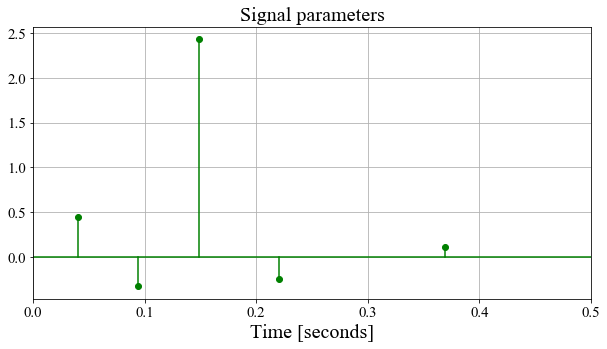

In [12]:
import sys
sys.path.append('..')
from frius import create_pulse_param
figsize = (10,5)

K = 5
period = 0.5
seed = 5
ck, tk = create_pulse_param(K=K, period=period, seed=seed, viz=True, figsize=figsize)

Assuming we know $K$, we need at least $2K$ adjacent Fourier coefficients for the annihilating filter constraint and we will pick those around baseband. We will use $2K+1$ coefficients so that we can have a filter that is symmetric around $0$ and therefore real-valued in the time domain.

So we first need to project our signal onto this bandlimited space between $[-K/\tau, K/\tau]$ Hz and take $2K+1$ samples. We can do this digitally with an ideal low-pass filter (1 within $[-K/\tau, K/\tau]$ Hz and 0 outside) as such:

\begin{align}
x_{BL}[n] &= \sum_{m=-K}^{K} X[m] \exp(j2\pi mn T_s/\tau)\\
\text{where} \hspace{0.3cm} X[m] &= \sum_{k=0}^{K-1}c_k\cdot \exp(-j2\pi m t_k/\tau)\\
\end{align}

and $T_s$ is the sampling period in seconds. We will again use a utility function ``sample_ideal_project`` that will provide us with the samples $x_{BL}[n]$ described above.

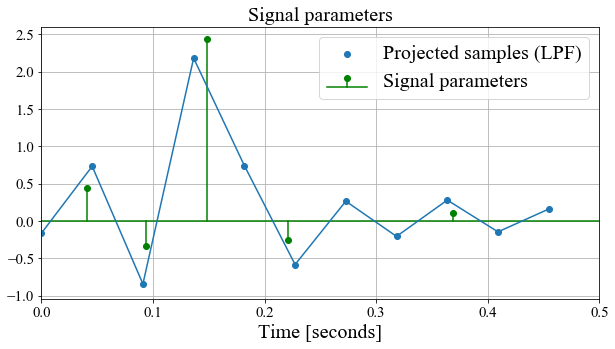

In [13]:
from frius import sample_ideal_project

x_samp, t_samp, fs_ind = sample_ideal_project(ck, tk, period, viz=True, figsize=figsize)

Now we can estimate our Fourier coefficients $X[m]$ from the samples $x_{BL}[n] = \sum_{m=-K}^{K} X[m] \exp(j2\pi mn T_s/\tau)$ by applying the DFT operation.

In [14]:
# ground truth Fourier coefficients within our lowpass filter
tk_grid, freqs_grid = np.meshgrid(tk, fs_ind/period)
fs_coeff = np.dot(np.exp(-1j*2*np.pi*freqs_grid*tk_grid), ck)/period

# estimate Fourier coefficients from samples
n_samples = len(x_samp)
t_samp_grid, fs_ind_grid = np.meshgrid(t_samp, fs_ind)
W_dft = np.exp(-1j*2*np.pi*fs_ind_grid*t_samp_grid/period) / n_samples
fs_coeff_hat = np.dot(W_dft, x_samp)
print("||fs_coeff - fs_coeff_hat||_2 = %f " % np.linalg.norm(fs_coeff-fs_coeff_hat))

||fs_coeff - fs_coeff_hat||_2 = 0.000000 


We can also use standard FFT functions but we may need to re-arrange terms as the second half usually corresponds to the negative frequencies.

In [15]:
Ts = period/n_samples
freqs_fft = np.fft.fftfreq(n_samples, Ts)
increasing_order = np.argsort(freqs_fft)
fs_coeff_hat_fft = (np.fft.fft(x_samp)/n_samples)[increasing_order]
print("||fs_coeff(fft) - fs_coeff(manual)||_2 = %f " % np.linalg.norm(fs_coeff_hat_fft-fs_coeff_hat))

||fs_coeff(fft) - fs_coeff(manual)||_2 = 0.000000 


We have also defined a utility function ``estimate_fourier_coeff`` that will estimate Fourier coefficients from uniform samples. This will be useful when we deal with arbitrary bandpass kernels and having to perform the "equalization" step.

In [16]:
from frius import estimate_fourier_coeff

fs_coeff_hat_util = estimate_fourier_coeff(x_samp, t_samp)
print("||fs_coeff(fft) - fs_coeff(util)||_2 = %f " % np.linalg.norm(fs_coeff_hat_fft-fs_coeff_hat))

||fs_coeff(fft) - fs_coeff(util)||_2 = 0.000000 


Now that we have our Fourier coefficients, we can obtain the annihilating filter $\mathbf{\hat{A}}$ to then find the time locations.

\begin{align}
\begin{bmatrix} 
X[0] & X[-1] &  \cdots & X[-K+1] \\ 
X[1] & X[0] &  \cdots & X[-K+2] \\
 & & \ddots &\\
X[K-1] & X[K-2] & \cdots & X[0]
\end{bmatrix} 
\cdot 
\begin{bmatrix} A[1] \\ A[2] \\ \vdots\\ A[K]\end{bmatrix}
&=
- \begin{bmatrix} X[1] \\ X[2] \\ \vdots\\ X[K]\end{bmatrix}
\end{align}

In [17]:
A_1K = solve_toeplitz(c_or_cr=(fs_coeff_hat[K:-1], fs_coeff_hat[K:0:-1]), b=-1*fs_coeff_hat[K+1:])
A_hat = np.insert(A_1K, 0, 1)   # append A[0]=1

Next, we find the zeros corresponding to the polynomial with coefficients given by $\mathbf{\hat{A}}$. And from the zeros we can then obtain the time locations $\{t_k\}_{k=0}^{K-1}$.

In [18]:
# find roots on unit circle
uk = np.roots(A_hat)
uk = uk / np.abs(uk)

# get time locations within [0, tau]
tk_hat = np.real(1j * period * np.log(uk) / (2 * np.pi))
tk_hat = tk_hat - np.floor(tk_hat / period) * period
tk_hat = np.sort(tk_hat)  # sort for comparison as `tk` are sorted

print("||tk - tk_hat||_2 = %f " % np.linalg.norm(tk-tk_hat))

||tk - tk_hat||_2 = 0.000000 


Finally, we can solve a linear system of equations for the amplitudes $\{c_k\}_{k=0}^{K-1}$.

In [19]:
tk_grid, fs_ind_grid = np.meshgrid(tk_hat, fs_ind)
Phi = np.exp(-1j*2*np.pi*fs_ind_grid*tk_grid/period)/period
ck_hat = np.real(lstsq(Phi, fs_coeff_hat)[0])

print("||ck - ck_hat||_2 = %f " % np.linalg.norm(ck-ck_hat))

||ck - ck_hat||_2 = 0.000000 


We have also defined utility functions to perform these three steps:
1. Obtain annihilating filter of length (K+1) from the Fourier coefficients.
2. Estimate time parameters from annihilating filter.
3. Estimate amplitude parameters from a least squares problem.

In [20]:
from frius import compute_ann_filt, estimate_time_param, estimate_amplitudes

ann_filt = compute_ann_filt(fs_coeff_hat, K)
tk_hat = estimate_time_param(ann_filt, period)
tk_hat = np.sort(tk_hat)
ck_hat = estimate_amplitudes(fs_coeff_hat, fs_ind/period, tk_hat, period)

print("||tk - tk_hat||_2 = %f " % np.linalg.norm(tk-tk_hat))
print("||ck - ck_hat||_2 = %f " % np.linalg.norm(ck-ck_hat))

||tk - tk_hat||_2 = 0.000000 
||ck - ck_hat||_2 = 0.000000 


Let's visualize the recovered parameters, although we could already observe from the errors that they are spot-on!

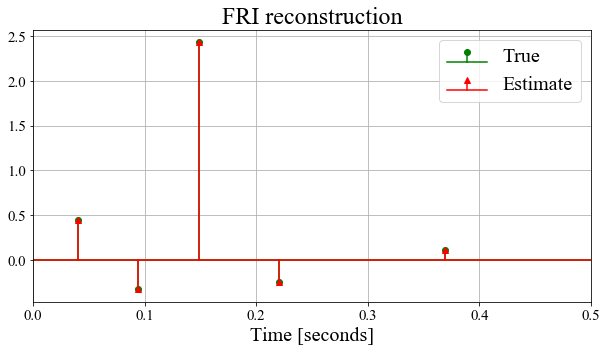

In [21]:
# visualize
plt.figure(figsize=figsize)
plt.title("FRI reconstruction")

baseline = plt.stem(tk, ck, 'g', markerfmt='go', label="True")[2]
plt.setp(baseline, color='g')
baseline.set_xdata([0, period])

baseline = plt.stem(tk_hat, ck_hat, 'r', markerfmt='r^', label="Estimate")[2]
plt.setp(baseline, color='r')
baseline.set_xdata([0, period])

plt.xlim([0,period])
plt.grid()
plt.legend(fontsize=20)
plt.xlabel("Time [seconds]");

We can then resynthesize the measured samples in similar way that we created them from the true $\{t_k\}_{k=0}^{K-1}$ and $\{c_k\}_{k=0}^{K-1}$ parameters, namely computing the Fourier coefficients and then the samples from the Fourier coefficients as was done by the utility function ``sample_ideal_project``.

||x_samp - x_samp_hat||_2 = 0.000000 


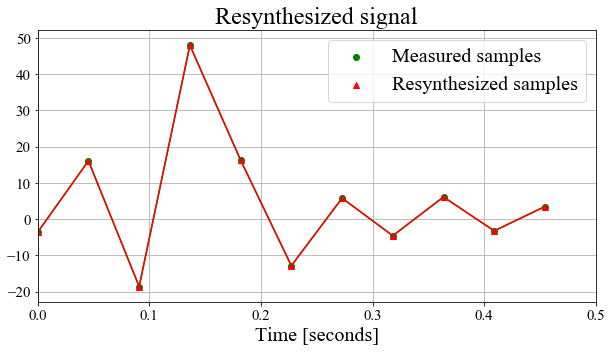

In [22]:
# resynthesize samples from estimated parameters
x_samp_hat = sample_ideal_project(ck_hat, tk_hat, period)[0]

# visualize
plt.figure(figsize=figsize)
plt.title("Resynthesized signal")
plt.scatter(t_samp, x_samp, c='g', label="Measured samples")
plt.plot(t_samp, x_samp, 'g')
plt.scatter(t_samp, x_samp_hat, c='r', marker='^', label="Resynthesized samples")
plt.plot(t_samp, x_samp_hat, 'r')
plt.xlim([0,period])
plt.grid()
plt.legend(fontsize=20)
plt.xlabel("Time [seconds]");

print("||x_samp - x_samp_hat||_2 = %f " % np.linalg.norm(tk-tk_hat))

<a id='interactive'></a>
# 6. Recovery of pulse stream parameters (interactive)

Using our utilities, we can create another function that will implement the whole pulse stream parameter recovery process! We will also create another function to evaluate the performance of our recovery.

||tk - tk_hat||_2 = 0.000000 
||ck - ck_hat||_2 = 0.000000 


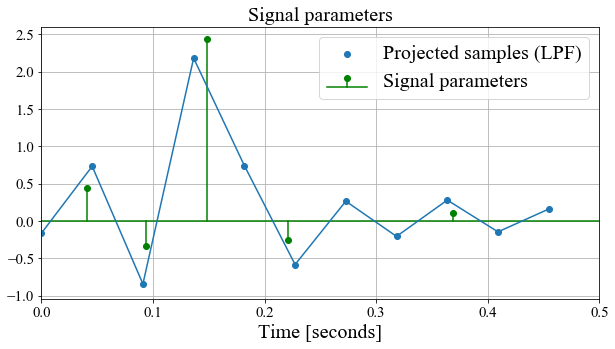

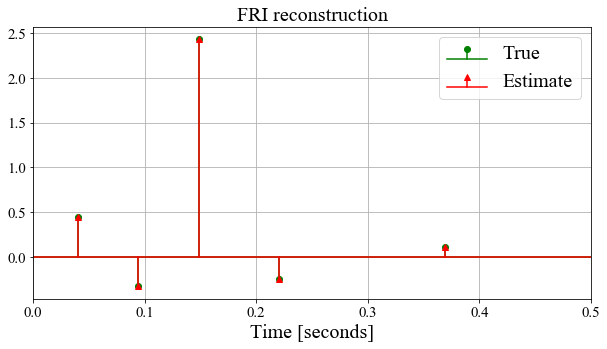

In [23]:
def recover_pulse_param(y_samp, t_samp, fs_ind, K):
    """
    Parameters
    ----------
    y_samp : numpy float array
        Sample values.
    t_samp : numpy float array
        Corresponding uniform sample locations of ``y_samp``.
    fs_ind : numpy int array
        Fourier coefficients to estimate.
    K : int
        Number of pulses to recover.
    """
    
    if len(y_samp)!=len(t_samp):
        raise ValueError("'y_samp' and 't_samp' must have equal length!")
        
    if len(y_samp) < (2*K+1):
        raise ValueError(
            "Need at least %d samples to recover %d pulses! Got $d samples."
                        % (2*K+1, K, len(y_samp)))
        
    if len(fs_ind) < len(y_samp):
        raise ValueError(
            "Need at least %d samples to recover %d Fourier coefficients! \
            Got $d samples."
            % (len(fs_ind), len(fs_ind), len(y_samp)))
        
    # derived parameters
    n_samples = len(y_samp)
    samp_time = t_samp[1]-t_samp[0]
    period = t_samp[-1]-t_samp[0]+samp_time
    
    # estimate Fourier coefficients
    fs_coeff_hat = estimate_fourier_coeff(y_samp, t_samp)
    
    # obtain annihilating filter
    ann_filt = compute_ann_filt(fs_coeff_hat, K)
    
    # estimate time locations as zeros of the annihilting filter polynomial
    tk_hat = estimate_time_param(ann_filt, period)
    
    # estimate amplitudes
    ck_hat = estimate_amplitudes(fs_coeff_hat, fs_ind/period, tk_hat, period)
    
    return ck_hat, tk_hat        
        
"""
Test utilities
"""
from frius import evaluate_recovered_param

K = 5
period = 0.5
seed = 5
ck, tk = create_pulse_param(K, period, seed)
y_samp, t_samp, fs_ind = sample_ideal_project(ck, tk, period, viz=True, figsize=figsize)
ck_hat, tk_hat = recover_pulse_param(y_samp, t_samp, fs_ind, K)
evaluate_recovered_param(ck, tk, ck_hat, tk_hat, viz=True, t_max=period, figsize=figsize)

Now we can create an interactive demo to vary the different signal parameters :)

In [24]:
def fri_recon_demo(K, period, seed):

    ck, tk = create_pulse_param(K, period, seed)
    y_samp, t_samp, fs_ind = sample_ideal_project(ck, tk, period)
    ck_hat, tk_hat = recover_pulse_param(y_samp, t_samp, fs_ind, K)
    evaluate_recovered_param(ck, tk, ck_hat, tk_hat, viz=True, t_max=period, figsize=figsize)

interactive_plot = widgets.interact(fri_recon_demo, K=(1, 10, 1), period=(0.1, 1.0, 0.1), seed=(0, 100, 1))

A Jupyter Widget

<a id='summary'></a>
# 7. Summary / takeaways

Some concluding remarks that we would like to make:

- Bandlimitedness is not necessary for perfect recovery. In fact, it is a special case of a signal that has _finite rate of innovation_ (FRI): $\rho=2f_m$ samples per second completely define it, where $f_m$ is the highest non-zero frequency component and $\rho$ denotes the rate of innovation.
- An arbitrary non-bandlimited signal (no priors) can have an _infinite_ rate of innovation $\rho=\infty$ making it impossible to perfectly reconstruct from a finite set of samples per unit of time. However, it can be projected into  a bandlimited space with an anti-aliasing filter and the bandlimited approximation can be perfectly recovered.
- One objective of "Sampling signals with finite rate of innovation" [Vetterli et. al] was to demonstrate that FRI signals can be perfectly reconstructed from a finite set of samples per unit of time, one of them being a finite sum of pulses $y(t) = \sum_{k=0}^{K-1} c_k h(t-t_k)$ over a finite duration $\tau$ from its bandlimited samples $\{y_{BL}[n]\}_{n=0}^{N-1}$. The signal $y(t)$ may not be bandlimited ($h(t)=\delta(t)$ has infinite bandwidth) but if we know the pulse shape, this is an FRI signal: $K$ locations $\{t_k\}_{k=0}^{K-1}$ and the $K$ amplitudes $\{c_k\}_{k=0}^{K-1}$ completely define it so $2K/\tau$ samples per second should be sufficient.
- In this notebook, we showed how to go about with the recovery of a finite sum of pulses over a finite duration.

In this notebook we dealt with the noiseless case. Later, we will talk about what to do under noise. However, we can already come up with part of the solution intuitively. If we consider the case of applying a bandlimited model to a non-bandlimited signal by projecting our signal into the bandlimited space, we are introducing noise in the form of a "model mismatch". We can reduce this model mismatch by projecting onto a _larger_ bandlimited space, i.e. by using an anti-aliasing filter with a larger bandwidth and taking more samples.

We can do exactly the same in the pulse stream case. Perhaps there is noise added to our samples or we have a model mismatch, we can then project onto a larger bandlimited space and take more samples, aka _oversample_, in order better approximate our signal.

### Further reading

More approachable explanation of FRI that also suggests an algorithm to deal with noise ([IEEE link](https://ieeexplore.ieee.org/document/4472241/)):

    T. Blu, P. L. Dragotti, M. Vetterli, P. Marziliano and L. Coulot, "Sparse Sampling of Signal Innovations," in IEEE Signal Processing Magazine, vol. 25, no. 2, pp. 31-40, March 2008.
    
Conference paper that looks at FRI in the communications scenario where we have a modulated pulse stream ([IEEE link](https://ieeexplore.ieee.org/document/997119/)):

    J. Kusuma, A. Ridolfi and M. Vetterli, "Sampling of communication systems with bandwidth expansion," 2002 IEEE International Conference on Communications. Conference Proceedings. ICC 2002 (Cat. No.02CH37333), 2002, pp. 1601-1605 vol.3.
    
    
Another more approachable explanation of FRI that suggests a more practical sampling kernel and discusses an application to ultrasound ([arXiv link](https://arxiv.org/abs/1003.2822)):

    R. Tur, Y. C. Eldar and Z. Friedman, "Innovation Rate Sampling of Pulse Streams With Application to Ultrasound Imaging," in IEEE Transactions on Signal Processing, vol. 59, no. 4, pp. 1827-1842, April 2011.
    
More on physically realizable kernels of compact support but quite advanced paper ([Infoscience EPFL link](https://infoscience.epfl.ch/record/104246/files/DragottiVB07.pdf)):

    P. L. Dragotti, M. Vetterli and T. Blu, "Sampling Moments and Reconstructing Signals of Finite Rate of Innovation: Shannon Meets Strang–Fix," in IEEE Transactions on Signal Processing, vol. 55, no. 5, pp. 1741-1757, May 2007.
    
Even more on compact support sampling kernels and viewing the sampling process with the projection "lens" ([IEEE link](https://ieeexplore.ieee.org/document/843002/)):

    M. Unser, "Sampling-50 years after Shannon," in Proceedings of the IEEE, vol. 88, no. 4, pp. 569-587, April 2000.
    